# Predicting Elections with "Mister P" (MRP, multi-level regression and post-stratification)

## Andrew Enfield, University of Washington Data 512 Autumn 2017

# Introduction

In this project I used Bayesian multi-level regression and post-stratification (MRP), and Python and [PyMC3](https://github.com/pymc-devs/pymc3) to adjust an unrepresentative sample of election preferences and predict the outcome of the 2016 US Presidential election. My results don't match the survey from which I used the raw data, possibly because I haven't used enough predictors (in the interest of simplicity). Nonetheless, the code and explanation show an attempt at learning and applying MRP using a language and MCMC framework that I haven't found used for such a purpose before. 

**NOTE:** I'm new to this concept and PyMC3, and did this work without review. If you happen upon this project and see things I did incorrectly or can do better, please let me know - it'll help me continue to learn.

# Background and related work

Most statistics assume implicitly or explicitly that the sample on which the statistic or inference is applied is _representative_ of the population of interest. I've found personally at least that this assumption is often violated: to a first approximation, I'm more likely to be correct when I assume that a sample is _not representative_.

An unrepresentative sample can cause the results based on the sample to be incorrect, and can have other bad effects, including missing signal from under-represented groups (for example, people that are harder to find in order to sample). The degree to which this is a problem in practice depends, at least, on the degree to which the sample is not representative and on the importance of the inference made based on the sample.

While a properly-run randomized controlled trial (RCT) can guarantee a representative sample, it's not always practical to run such an experiment. Furthermore, requiring an RCT automatically excludes numerous convenience or other samples. This is especially unfortunate given the explosion in recent years of accessible data that likely contains information but that isn't known to be representative of a larger population.

It is possible to adjust unrepresentative data after the fact and generate results that more closely hew to the results that would have been obtained from a representative sample. While this isn't a silver bullet, and can be difficult, when done successfully it can make results more useful. The New York Times article [How One 19-Year-Old Illinois Man Is Distorting National Polling Averages](https://www.nytimes.com/2016/10/13/upshot/how-one-19-year-old-illinois-man-is-distorting-national-polling-averages.html) describes general issues with unrepresentative samples as well as with adjusting these samples.

In more detail, two of multiple methods that can be used to adjust samples are [propensity score matching](https://en.wikipedia.org/wiki/Propensity_score_matching) and [post-stratification](https://onlinecourses.science.psu.edu/stat506/node/29). I use post-stratification in this work.

Generally, post-stratification involves three steps:

1. Dividing the population into "cells", one for each combination of values in the variables of interest. For example, in this notebook I know the sex, race/ethnicity, and state for each respondent. The Pew Research Center source data (documented in the [README](README.md)) has two values for sex, five values for race/ethnicity, and 51 values for state (including the District of Columbia). This makes for 2 x 5 x 51 = 510 combinations of values, or cells. 

2. For each cell, estimating the statistic in question for observations with the characteristics for that cell and finding the proportion of the overall population in that cell. I estimate the probability of people with the particular combination of sex, race/ethnicity, and state expressing a preference for Trump, with the complement of that probability being the preference for Clinton, using the Pew Research Center poll data. I obtain the proportion of the US population for each cell from the US Census Bureau's Current Population Survey (CPS). Then, the contribution of that cell to the overall statistic is calculated by multiplying the estimated statistic and the population.

3. Calculate the final estimate as an average of all cells, weighted by the population in each cell. 

In this project I use a particular approach called "multi-level regression and post-stratification" (MRP), which is distinguished by its use of Bayesian multi-level (or hierarchical) regression. As related to the previous steps, this is the particular implementation of the "estimate the statistic in question" part of step two above. Bayesian regression uses models where the regression coefficients are defined as parameters to be estimated based on the observed data as well as pre-chosen distributions - here, I use primarily normal distributions - using Bayes' Rule. The "multi-level" part of the implementation refers to the use of additional parameters that are also estimated and that are "above" or shared by multiple lower-level parameters. The model below, for example, defines a regression coefficient/parameter for each state, as well as a higher level "hyper" parameter that is shared by all states. The value of this higher level parameter depends on the values of all of the lower level parameters, generally in proportion to the amount of data associated with each lower level parameter. As a result, parameters associated with smaller amounts of data are automatically - by Bayes' Rule - "shrunk" toward the mean value, while parameters associated with more data are defined primarily by the data itself.

Note also that while Bayesian multi-level regression has advantages, any approach - including simple OLS logistic regression - could be used to find the estimate. 

MRP has been implemented and popularized by academics including Andrew Gelman, and others, including via the following papers and blog posts (this is a non-exhaustive list):
- [Forecasting elections with non-representative polls](http://www.stat.columbia.edu/~gelman/research/published/forecasting-with-nonrepresentative-polls.pdf); Wang, Rothschild, Goel, Gelman.
- [Deep Interactions with MRP: Election Turnout and Voting Patterns Among Small Electoral Subgroups](http://www.stat.columbia.edu/~gelman/research/published/misterp.pdf); Ghitza, Gelman.
- [Estimating State Public Opinion With Multi-Level Regression and Poststratification using R](http://www.princeton.edu/~jkastell/MRP_primer/mrp_primer.pdf); Kastellec, Lax, Phillips.
- [We Gave Four Good Pollsters the Same Raw Data. They Had Four Different Results.](https://www.nytimes.com/interactive/2016/09/20/upshot/the-error-the-polling-world-rarely-talks-about.html); Cohn.
- [Mister P can solve problems with survey weighting](http://andrewgelman.com/2016/10/12/31398/); Gelman.
- [Mister P: What’s its secret sauce?](http://andrewgelman.com/2013/10/09/mister-p-whats-its-secret-sauce/); Gelman.

There are a variety of libraries and packages for doing Bayesian inference and analysis, in this work I use [PyMC3](https://github.com/pymc-devs/pymc3), which is a "Python package for Bayesian statistical modeling and Probabilistic Machine Learning which focuses on advanced Markov chain Monte Carlo and variational fitting algorithms."




# Methods

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm

# to generate the full matrix of input data from a list of possibilities
import itertools 

# to sanity check some pymc3 results against normal logistic regression results
from sklearn.linear_model import LogisticRegression 

In [2]:
# to enable viewing longer Series and DataFrame instances
pd.set_option('display.max_rows', 500)

## Load and prepare Pew poll data for voter preferences

In [3]:
# TODO move to local dir and check in when it looks good
d = pd.read_csv('~/OneDrive/Personal/School/Master\'s/DATA 512/Project/Oct16/pew_poll.csv')
d.shape

(2583, 6)

In [4]:
d[:2]

,state,sex,q10horseGP,race3m1,race3m2,weight
0,Minnesota,Male,Trump/lean Trump,"White (e.g., Caucasian, European, Irish, Itali...",NaN,2.088235
1,Delaware,Female,Clinton/lean Clinton,"White (e.g., Caucasian, European, Irish, Itali...",NaN,1.264706


In [5]:
#from collections import defaultdict
racethn_to_index = {
    "White (e.g., Caucasian, European, Irish, Italian, Arab, Middle Eastern)": 1,
    "Black or African-American (e.g., Negro, Kenyan, Nigerian, Haitian)": 2,
    "Asian or Asian-American (e.g., Asian Indian, Chinese, Filipino, Vietnamese or other Asian origin groups)": 3,
    "Some other race (SPECIFY____ IF NEEDED: What race or races is that?)": 4,
    "Native American/American Indian/Alaska Native (VOL.)": 5,
    "Pacific Islander/Native Hawaiian (VOL.)": 6,
    "Hispanic/Latino (VOL.) (e.g., Mexican, Puerto Rican, Cuban)": 7,
    "Don't know (VOL.)": 8,
    "Refused (e.g., non-race answers like American, Human, purple) (VOL.)": 9
}

d['race3m1_index'] = d['race3m1'].map(racethn_to_index)
d['race3m2_index'] = d['race3m2'].map(racethn_to_index)

In [6]:
def get_racecmb(row):
    if ((row['race3m2_index'] > 0) & (row['race3m2_index'] < 8)):
        return 'Mixed Race'
    elif (row['race3m1_index'] == 1):
        return 'White'
    elif (row['race3m1_index'] == 2):
        return 'Black or African-American'
    elif (row['race3m1_index'] == 3):
        return 'Asian or Asian-American'
    elif (row['race3m1_index'] >= 4 & row['race3m1_index'] <= 7):
        return 'Or some other race'
    elif ((row['race3m1_index'] >= 8) & (row['race3m1_index'] <= 9)):
        return 'Dont know/Refused (VOL.)'

In [7]:
d['racecmb'] = d.apply(get_racecmb, axis=1)

In [8]:
d['racecmb'].value_counts(dropna=False)

White                        1935
Black or African-American     258
Or some other race            230
Asian or Asian-American        83
Mixed Race                     77
Name: racecmb, dtype: int64

**TODO** sanity check above numbers... are they right?

In [9]:
d['q10horseGP'].value_counts(dropna=False)

Clinton/lean Clinton     972
Trump/lean Trump         858
Not registered           466
Johnson/lean Johnson     124
DK-refused to lean        76
Stein/lean Stein          57
Other-refused to lean     30
Name: q10horseGP, dtype: int64

In [10]:
d_only = d[(d['q10horseGP'] == 'Clinton/lean Clinton') | 
           (d['q10horseGP'] == 'Trump/lean Trump')]
d_only.shape

(1830, 9)

In [11]:
d_only['q10horseGP'].value_counts(dropna=False)

Clinton/lean Clinton    972
Trump/lean Trump        858
Name: q10horseGP, dtype: int64

**TODO** note revisit of states now that we've filtered.

In [12]:
len(d_only['state'].unique())

50

Talk about how we should have 51...

In [13]:
d_only['state'].value_counts(dropna=False)

California              158
Texas                   133
Florida                 123
New York                121
Pennsylvania             75
Ohio                     72
New Jersey               68
Georgia                  62
Michigan                 61
North Carolina           61
Virginia                 60
Illinois                 57
Minnesota                48
Arizona                  45
Washington               45
Wisconsin                43
Tennessee                37
Missouri                 34
Kentucky                 34
Colorado                 33
Indiana                  33
South Carolina           33
Maryland                 30
Oregon                   29
Louisiana                28
Massachusetts            28
Oklahoma                 26
Alabama                  22
Iowa                     19
Kansas                   19
Nevada                   18
Idaho                    18
Connecticut              17
Utah                     15
West Virginia            15
Mississippi         

In [14]:
d_only[d_only['state'] == 'South Dakota']

,state,sex,q10horseGP,race3m1,race3m2,weight,race3m1_index,race3m2_index,racecmb


We don't have any rows in our two-party data w/ South Dakota, so absent any extra work on our part, we won't have a dummy indicator variable for SD, which'll make it harder to do stuff w/ the state later. We'll add it here when we're forming the dummies w/ states.

In [15]:
# add South Dakota, using the same index to make sure we don't extra cols (prob a better way to do this)
state_dummies = pd.concat([pd.get_dummies(d_only['state']), 
                           pd.Series(name='South Dakota', data=np.repeat(0, len(d_only)), index=d_only.index)], axis=1)
# alphabetize to put SD in the right spot
state_dummies = state_dummies.reindex(sorted(state_dummies.columns), axis=1)
state_dummies.shape

(1830, 51)

In [16]:
state_count = len(state_dummies.columns.values)
state_count

51

In [17]:
state_number_to_name = dict(list(zip(range(0,51), sorted(state_dummies.columns.values))))
state_number_to_name

{0: 'Alabama',
 1: 'Alaska',
 2: 'Arizona',
 3: 'Arkansas',
 4: 'California',
 5: 'Colorado',
 6: 'Connecticut',
 7: 'Delaware',
 8: 'District of Columbia',
 9: 'Florida',
 10: 'Georgia',
 11: 'Hawaii',
 12: 'Idaho',
 13: 'Illinois',
 14: 'Indiana',
 15: 'Iowa',
 16: 'Kansas',
 17: 'Kentucky',
 18: 'Louisiana',
 19: 'Maine',
 20: 'Maryland',
 21: 'Massachusetts',
 22: 'Michigan',
 23: 'Minnesota',
 24: 'Mississippi',
 25: 'Missouri',
 26: 'Montana',
 27: 'Nebraska',
 28: 'Nevada',
 29: 'New Hampshire',
 30: 'New Jersey',
 31: 'New Mexico',
 32: 'New York',
 33: 'North Carolina',
 34: 'North Dakota',
 35: 'Ohio',
 36: 'Oklahoma',
 37: 'Oregon',
 38: 'Pennsylvania',
 39: 'Rhode Island',
 40: 'South Carolina',
 41: 'South Dakota',
 42: 'Tennessee',
 43: 'Texas',
 44: 'Utah',
 45: 'Vermont',
 46: 'Virginia',
 47: 'Washington',
 48: 'West Virginia',
 49: 'Wisconsin',
 50: 'Wyoming'}

## Create data frame of indicator variables

In [18]:
d_only_dummies = pd.concat([pd.get_dummies(d_only['sex'], drop_first=True),
                            pd.get_dummies(d_only['racecmb']),
                            state_dummies], axis=1)
d_only_dummies.shape

(1830, 57)

In [19]:
d_only_dummies[:2]

,Male,Asian or Asian-American,Black or African-American,Mixed Race,Or some other race,White,Alabama,Alaska,Arizona,Arkansas,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Generate data frames of all cells (indicator and otherwise), for use as input data

In [20]:
all_cells_list = list(itertools.product(np.sort(d_only['sex'].unique()), 
                                        np.sort(d_only['racecmb'].unique()),
                                        sorted(state_number_to_name.values())))
all_cells_list[:2]

[('Female', 'Asian or Asian-American', 'Alabama'),
 ('Female', 'Asian or Asian-American', 'Alaska')]

In [21]:
len(all_cells_list)

510

In [22]:
all_cells = pd.DataFrame(all_cells_list, columns=['sex','racecmb','state'])
all_cells[:2]

,sex,racecmb,state
0,Female,Asian or Asian-American,Alabama
1,Female,Asian or Asian-American,Alaska


In [23]:
# remove sex_Female since we only need one col for sex
all_cells_dummies = pd.get_dummies(all_cells).drop('sex_Female', 1)
all_cells_dummies[:3]

,sex_Male,racecmb_Asian or Asian-American,racecmb_Black or African-American,racecmb_Mixed Race,racecmb_Or some other race,racecmb_White,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Estimate voter preferences using multi-level regression and PyMC3

In [24]:
y_obs_categorical = pd.Categorical(d_only['q10horseGP'])
y_obs = y_obs_categorical.codes

sum(y_obs == 0), sum(y_obs == 1)

(972, 858)

In [25]:
y_obs_categorical

[Trump/lean Trump, Clinton/lean Clinton, Trump/lean Trump, Trump/lean Trump, Clinton/lean Clinton, ..., Trump/lean Trump, Clinton/lean Clinton, Clinton/lean Clinton, Clinton/lean Clinton, Clinton/lean Clinton]
Length: 1830
Categories (2, object): [Clinton/lean Clinton, Trump/lean Trump]

Clinton is 0, Trump is 1.

**TODO** Note when writing docs that I have a lot of simpler and other models in the research notebook, and that I'm only showing the final one here.

In [26]:
vals_sex = d_only_dummies.values[:,0]
vals_racecmb = d_only_dummies.values[:,1:6]
vals_state = d_only_dummies.values[:,6:]

vals_sex.shape, vals_racecmb.shape, vals_state.shape

((1830,), (1830, 5), (1830, 51))

In [27]:
def standard_logistic(x):
    return 1 / (1 + np.exp(-x))

In [28]:
with pm.Model() as model_complete:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=10)
    
    mu_race = pm.Normal('mu_race', mu=0, sd=10)
    sigma_race = pm.HalfCauchy('sigma_race', 5)
    beta_race = pm.Normal('beta_race', mu=mu_race, sd=sigma_race, 
                          shape=len(d_only['racecmb'].unique()))
    
    mu_state = pm.Normal('mu_state', mu=0, sd=10)
    beta_state = pm.Normal('beta_state', mu=mu_state, sd=1, 
                          shape=state_count)

    mu = alpha + \
         vals_sex * beta_sex + \
         pm.math.dot(vals_racecmb, beta_race) + \
         pm.math.dot(vals_state, beta_state)
            
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    # calculate the probability as part of the chain (can't use aggregate stats - must
    # calc based on each step in the chain, since each step is a plausible set of values)
    all_cells_values_matrix = all_cells_dummies.values
    probs = pm.Deterministic('probs', standard_logistic(alpha + \
                 all_cells_values_matrix[:,0] * beta_sex + \
                 pm.math.dot(all_cells_values_matrix[:,1:6], beta_race) + \
                 pm.math.dot(all_cells_values_matrix[:,6:], beta_state)))

    
    y = pm.Bernoulli('y', theta, observed=y_obs)

In [51]:
np.random.seed(42)

In [52]:
with model_complete:
    trace_complete = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1999/2000 [09:22<00:00,  4.34it/s]/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
100%|██████████| 2000/2000 [09:23<00:00,  3.55it/s]


In [53]:
varnames_model_complete = ['alpha', 'beta_sex', 
                           'mu_race', 'sigma_race', 'beta_race',
                           'mu_state', 'beta_state']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b2980b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b85ad68>]], dtype=object)

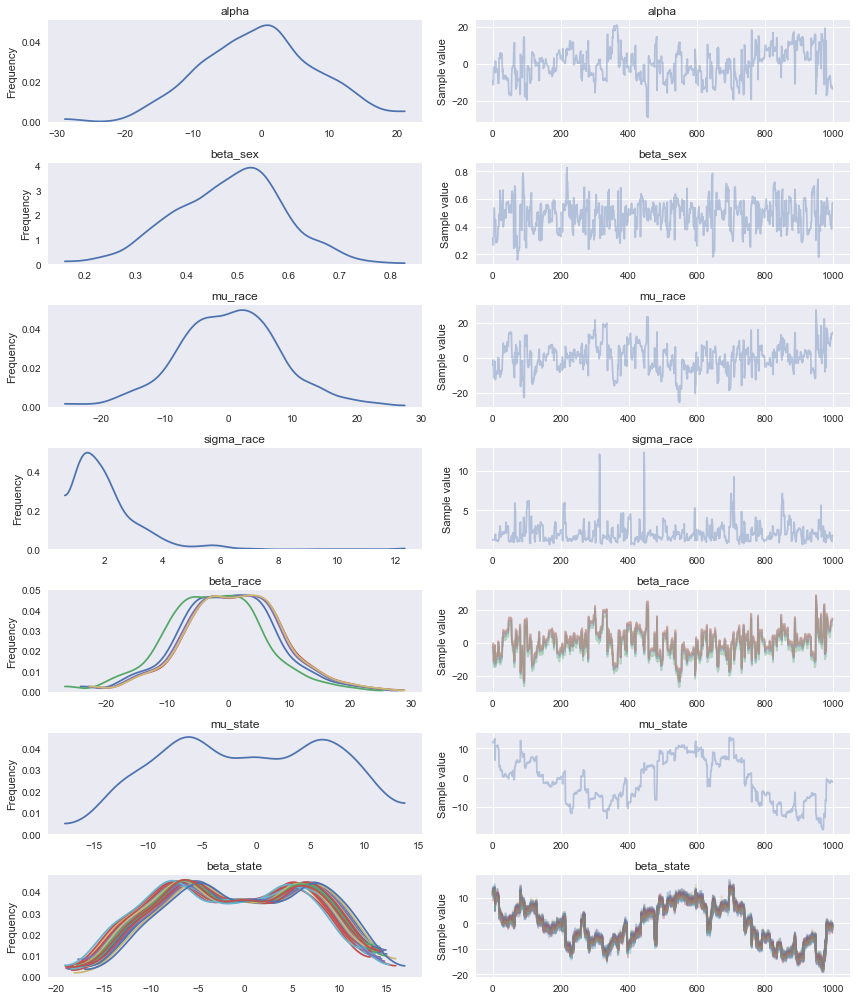

In [54]:
pm.traceplot(trace_complete, varnames_model_complete)

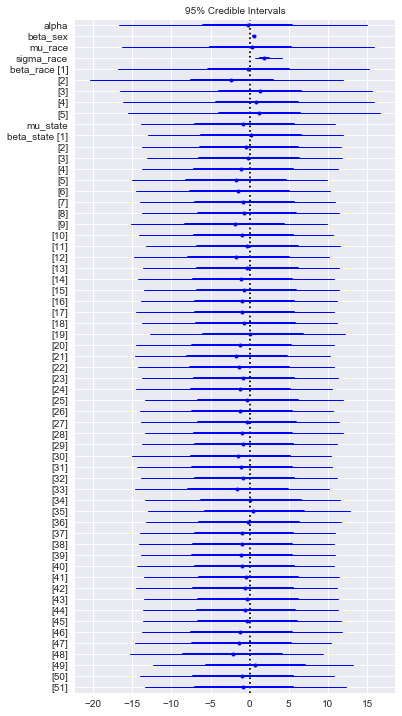

In [55]:
plt.figure(figsize=(6,11))
pm.forestplot(trace_complete, varnames_model_complete)

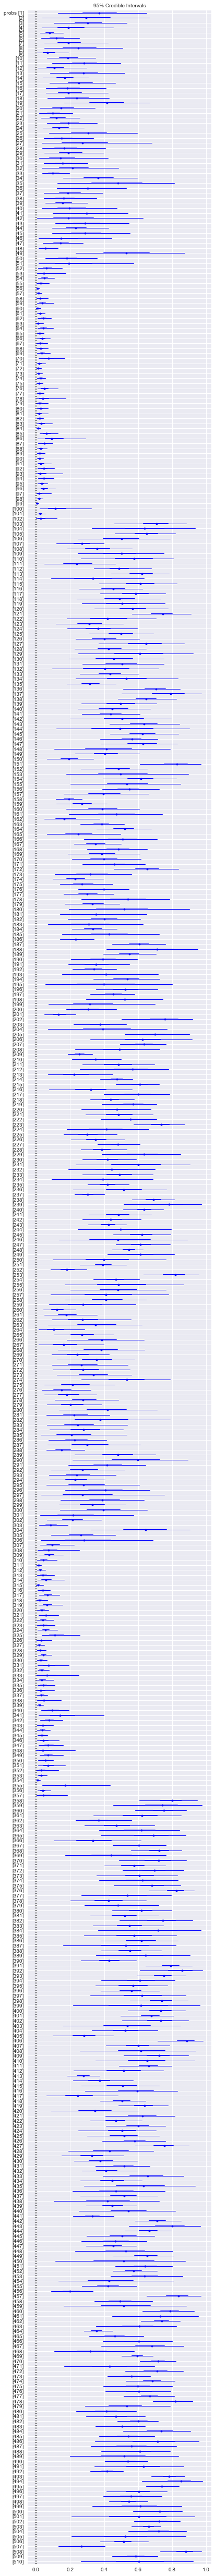

In [56]:
plt.figure(figsize=(6,80))
pm.forestplot(trace_complete, ['probs'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12806a940>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x129aa9a58>]], dtype=object)

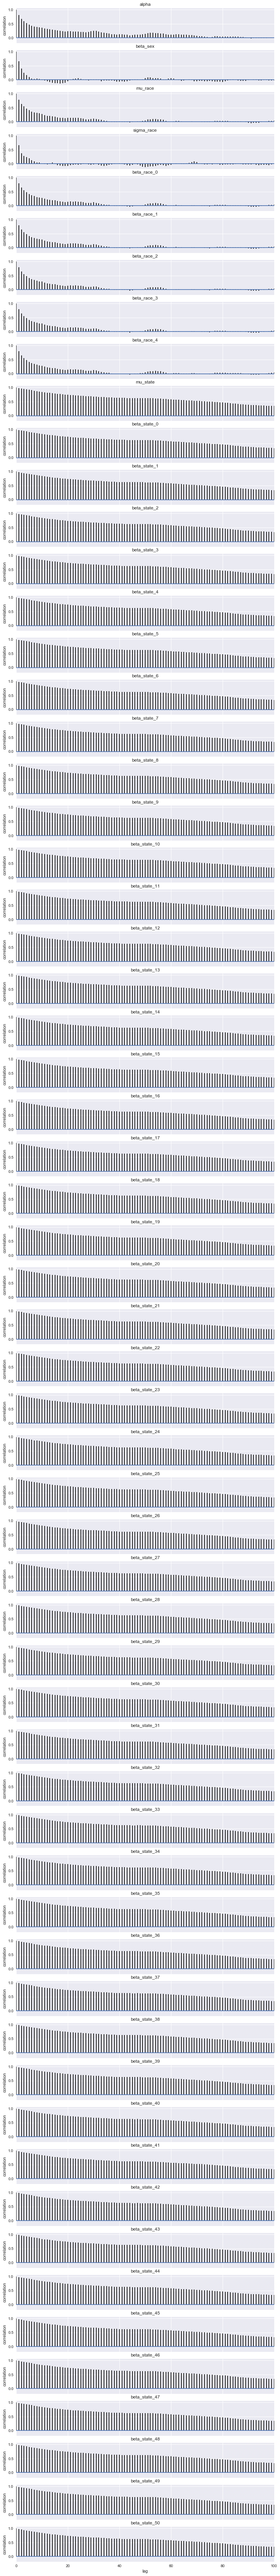

In [57]:
pm.autocorrplot(trace_complete, varnames_model_complete)

In [58]:
pm.df_summary(trace_complete, varnames_model_complete)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.278894,8.443848,0.680041,-16.757765,15.042520
beta_sex,0.482772,0.106403,0.006286,0.284568,0.691439
mu_race,0.151818,7.998949,0.617984,-16.286200,15.890610
sigma_race,2.125906,1.232728,0.079750,0.651144,4.193816
beta_race__0,-0.177194,8.021948,0.620175,-16.794217,15.230752
beta_race__1,-2.359403,8.031224,0.623189,-20.446508,11.892603
beta_race__2,1.266135,8.001975,0.619688,-16.608958,15.644659
beta_race__3,0.839721,8.006709,0.621563,-16.171507,15.940593
beta_race__4,1.209273,8.000559,0.620649,-15.579958,16.702831
mu_state,-0.938978,7.493509,0.730481,-13.938650,10.892101


**TODO** could check book(s) for auto correlation info... if it's ok but just slows sampling, then as long as we get roughly the same output, i could say it's ok here?

### Calculate and add probabilities per cell

In [256]:
def classify_with_matrix(values_matrix, threshold, trace_data, varnames, add_intercept=False):
    if add_intercept:
        # add a column at the beginning with all ones, to match up w/ something like an alpha param
        values_matrix = np.c_[np.ones(len(values_matrix)), values_matrix]

    mean_vals = pm.df_summary(trace_data, varnames)['mean'].values

    mu = np.dot(values_matrix, mean_vals)

    prob = standard_logistic(mu)
    return prob, prob > threshold

In [257]:
probs, _ = classify_with_matrix(all_cells_dummies, 0.5, trace_complete,
                                ['alpha','beta_sex','beta_race','beta_state'], add_intercept=True)
probs.shape

(510,)

In [258]:
all_cells['trump_prob'] = probs
all_cells.shape

(510, 4)

In [259]:
all_cells[:2]

,sex,racecmb,state,trump_prob
0,Female,Asian or Asian-American,Alabama,0.367146
1,Female,Asian or Asian-American,Alaska,0.318009


### Remember probability data from the chain itself, for comparison and possibly to show uncertainty

In [36]:
all_cells_with_trace = pd.concat([all_cells, pm.df_summary(trace_complete, ['probs']).reset_index(drop=True)], axis=1)
all_cells_with_trace[:2]

,sex,racecmb,state,mean,sd,mc_error,hpd_2.5,hpd_97.5
0,Female,Asian or Asian-American,Alabama,0.378262,0.134920,0.004040,0.115265,0.628485
1,Female,Asian or Asian-American,Alaska,0.337771,0.173755,0.006794,0.052019,0.671331


## Load and prepare CPS data for population calculations

In [37]:
d_pop = pd.read_csv('~/OneDrive/Personal/School/Master\'s/DATA 512/Project/cps_population.csv')
d_pop.shape

(185487, 4)

In [38]:
d_pop[:2]

,RACE,WTSUPP,SEX,STATECENSUS
0,White,1132.05,Female,Maine
1,White,1077.54,Female,Maine


### Map CPS values to Pew values

Based on the quick examination of the fields I'm using right now, I think sex and state are actually good to go w/ no further work. For race I'll need to map, as CPS has a lot more values.

In [39]:
map_cps_race_to_pew_racecmb = {
    'White':'White',
    'Black/Negro':'Black or African-American',
    'Asian only':'Asian or Asian-American',
    'American Indian/Aleut/Eskimo':'Or some other race',
    'White-American Indian':'Mixed Race',
    'White-Black':'Mixed Race',
    'Hawaiian/Pacific Islander only':'Or some other race',
    'White-Asian':'Mixed Race',
    'White-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-American Indian':'Mixed Race',
    'Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'White-Black-American Indian':'Mixed Race',
    'White-Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-Asian':'Mixed Race',
    'White-Black-Asian':'Mixed Race',
    'Four or five races, unspecified':'Mixed Race',
    'Black-Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Asian':'Mixed Race',
    'Two or three races, unspecified':'Mixed Race',
    'American Indian-Asian':'Mixed Race',
    'White-Black-American Indian-Asian':'Mixed Race',
    'White-Black--Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Hawaiian/Pacific Islander':'Mixed Race',
    'American Indian-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-American Indian-Asian':'Mixed Race'
}
map_cps_race_to_pew_racecmb

d_pop['mapped_racecmb'] = d_pop['RACE'].map(map_cps_race_to_pew_racecmb)

d_pop['mapped_racecmb'].value_counts(dropna=False)

White                        142972
Black or African-American     22872
Asian or Asian-American       10709
Mixed Race                     4690
Or some other race             4244
Name: mapped_racecmb, dtype: int64

## Calculate predicted votes based on preferences and cell populations

In [40]:
population_by_cell = d_pop.groupby(['SEX','mapped_racecmb','STATECENSUS'], as_index=False)['WTSUPP'].sum()
population_by_cell.shape

(510, 4)

In [41]:
all_cells_with_pop = all_cells_with_trace.merge(population_by_cell, 
                                                left_on=['sex','racecmb','state'], 
                                                right_on=['SEX','mapped_racecmb','STATECENSUS'],
                                                validate='1:1')#[['sex','racecmb','state','trump_prob','WTSUPP']]
all_cells_with_pop.drop(columns=['SEX','mapped_racecmb','STATECENSUS'], inplace=True)
all_cells_with_pop.rename(columns={'WTSUPP':'population'}, inplace=True)
all_cells_with_pop[:3]

,sex,racecmb,state,mean,sd,mc_error,hpd_2.5,hpd_97.5,population
0,Female,Asian or Asian-American,Alabama,0.378262,0.134920,0.004040,0.115265,0.628485,51040.97
1,Female,Asian or Asian-American,Alaska,0.337771,0.173755,0.006794,0.052019,0.671331,28853.07
2,Female,Asian or Asian-American,Arizona,0.317274,0.107439,0.003018,0.115101,0.534268,124310.67


In [42]:
# confirm that the totals are the same in both our cell data and in the CPS data
round(all_cells_with_pop['population'].sum()), round(d_pop['WTSUPP'].sum())

(318868490.0, 318868490.0)

In [43]:
def add_vote_columns(df, population_col, prob_col, vote_col_prefix):
    """TODO doc, prob_col is prob of Trump vote"""
    df_new = df.copy()
    df_new[f"{vote_col_prefix}_clinton"] = np.round(df_new[population_col] * (1 - df_new[prob_col])).astype(int)
    df_new[f"{vote_col_prefix}_trump"] = np.round(df_new[population_col] * df_new[prob_col]).astype(int)

    return df_new

In [44]:
all_cells_with_results = add_vote_columns(all_cells_with_pop, 'population', 'trump_prob', 'votes')
all_cells_with_results[:3]

KeyError: 'trump_prob'

## Calculate MRP prediction

In [474]:
def get_counts_and_proportions(label, clinton_count, trump_count, verbose=True):
    """TODO doc - return DF row for saving/overall comparison, optionally show"""
    all_rows_count = clinton_count + trump_count
    clinton_prop = clinton_count / all_rows_count
    trump_prop = trump_count / all_rows_count
    
    if verbose:
        print(f"Total  \t{all_rows_count:,}")
        print(f"Clinton\t{clinton_count:,} ({clinton_prop:.1%})")
        print(f"Trump  \t{trump_count:,} ({trump_prop:.1%})")
    
    return pd.DataFrame.from_records(data=[(clinton_count, clinton_prop, trump_count, trump_prop, all_rows_count)], 
                                     index=[label],
                                     columns=['Clinton count','Clinton proportion','Trump count','Trump proportion','Total count'])

Get results and start DF for comparison...

In [477]:
result_comparison = get_counts_and_proportions("Bayesian MRP", 
                                               all_cells_with_results['votes_clinton'].sum(),
                                               all_cells_with_results['votes_trump'].sum())

Total  	318,868,482
Clinton	180,742,046 (56.7%)
Trump  	138,126,436 (43.3%)


## Calculate prediction from poll using poll weights

In [275]:
d_only['weight'].sum()

4904.5

In [276]:
d_only.groupby(['q10horseGP'])['weight'].sum()

q10horseGP
Clinton/lean Clinton    2628.352941
Trump/lean Trump        2276.147059
Name: weight, dtype: float64

In [487]:
result_comparison = pd.concat([result_comparison, get_counts_and_proportions("Pew Research, weighted",
    round(d_only[d_only['q10horseGP'] == 'Clinton/lean Clinton']['weight'].sum()),
    round(d_only[d_only['q10horseGP'] == 'Trump/lean Trump']['weight'].sum()))])

Total  	4,904.0
Clinton	2,628.0 (53.6%)
Trump  	2,276.0 (46.4%)


,Clinton count,Clinton proportion,Trump count,Trump proportion,Total count
Bayesian MRP,180742046.0,0.566823,138126436.0,0.433177,318868482.0
"Pew Research, weighted",2628.0,0.535889,2276.0,0.464111,4904.0


And if we don't use the weights, just for comparison?

In [488]:
result_comparison = pd.concat([result_comparison, get_counts_and_proportions("Pew Research, unweighted",
    len(d_only[d_only['q10horseGP'] == 'Clinton/lean Clinton']),
    len(d_only[d_only['q10horseGP'] == 'Trump/lean Trump']))])

result_comparison

Total  	1,830
Clinton	972 (53.1%)
Trump  	858 (46.9%)


,Clinton count,Clinton proportion,Trump count,Trump proportion,Total count
Bayesian MRP,180742046.0,0.566823,138126436.0,0.433177,318868482.0
"Pew Research, weighted",2628.0,0.535889,2276.0,0.464111,4904.0
"Pew Research, unweighted",972.0,0.531148,858.0,0.468852,1830.0


## Does adjusting for likelihood to vote change the MRP predictions?

In [279]:
d_voting = pd.read_csv('~/OneDrive/Personal/School/Master\'s/DATA 512/Project/cps_votes.csv')
d_voting.shape

(131389, 5)

In [280]:
d_voting[:2]

,RACE,WTFINL,SEX,STATEFIP,VOTED
0,White,1878.9962,Male,Alabama,Voted
1,White,1519.4506,Female,Alabama,Did not vote


In [281]:
d_voting['mapped_racecmb'] = d_voting['RACE'].map(map_cps_race_to_pew_racecmb)
d_voting['mapped_racecmb'].value_counts(dropna=False)

White                        104857
Black or African-American     14055
Asian or Asian-American        6972
Mixed Race                     2901
Or some other race             2604
Name: mapped_racecmb, dtype: int64

In [282]:
d_voting_pop_by_cell = d_voting.groupby(['SEX','mapped_racecmb','STATEFIP'], as_index=False)['WTFINL'].sum()
d_voting_pop_by_cell.shape

(508, 4)

Hmm... that should be 2 x 5 x 51 = 510. Which states don't have all one row for each cell?

In [283]:
(d_voting_pop_by_cell['STATEFIP'].unique())[d_voting_pop_by_cell.groupby('STATEFIP').size() < 10]

array(['Maine', 'Vermont'], dtype=object)

In [284]:
d_voting_pop_by_cell[d_voting_pop_by_cell['STATEFIP'] == 'Maine']

,SEX,mapped_racecmb,STATEFIP,WTFINL
19,Female,Asian or Asian-American,Maine,9754.6069
70,Female,Black or African-American,Maine,4462.1727
121,Female,Mixed Race,Maine,13686.0606
222,Female,White,Maine,644054.1601
273,Male,Asian or Asian-American,Maine,5334.7327
324,Male,Black or African-American,Maine,14303.7411
375,Male,Mixed Race,Maine,20999.6773
426,Male,Or some other race,Maine,5108.2904
476,Male,White,Maine,598546.5575


In [285]:
d_voting_pop_by_cell[d_voting_pop_by_cell['STATEFIP'] == 'Vermont']

,SEX,mapped_racecmb,STATEFIP,WTFINL
45,Female,Asian or Asian-American,Vermont,7194.2980
96,Female,Black or African-American,Vermont,3659.6508
147,Female,Mixed Race,Vermont,7383.7707
197,Female,Or some other race,Vermont,3078.2986
248,Female,White,Vermont,292484.9831
299,Male,Asian or Asian-American,Vermont,8141.2312
350,Male,Black or African-American,Vermont,4593.6401
401,Male,Mixed Race,Vermont,8969.2326
502,Male,White,Vermont,283089.8951


Turns out that Maine is missing females of 'Or some other race' and Vermont is missing males of 'Or some other race'.

In [286]:
d_voted_pop_by_cell = d_voting[d_voting['VOTED'] == 'Voted'].groupby(['SEX','mapped_racecmb','STATEFIP'], as_index=False)['WTFINL'].sum()
d_voted_pop_by_cell.shape

(490, 4)

In [287]:
d_voted_pop_by_cell[:2]

,SEX,mapped_racecmb,STATEFIP,WTFINL
0,Female,Asian or Asian-American,Alabama,1822.7216
1,Female,Asian or Asian-American,Alaska,4588.3356


In [288]:
d_didnotvote_pop_by_cell = d_voting[d_voting['VOTED'] == 'Did not vote'].groupby(['SEX','mapped_racecmb','STATEFIP'], as_index=False)['WTFINL'].sum()
d_didnotvote_pop_by_cell.shape

(475, 4)

In [289]:
d_didnotvote_pop_by_cell[:2]

,SEX,mapped_racecmb,STATEFIP,WTFINL
0,Female,Asian or Asian-American,Alabama,3167.1616
1,Female,Asian or Asian-American,Alaska,3133.0862


In [290]:
def get_voted_proportion(g):
    voted_count = g[g['VOTED'] == 'Voted']['WTFINL'].sum()
    if np.isnan(voted_count): # if there are no vote rows, then we had zero (don't think there's a way to do this via a built-in function)
        voted_count = 0
    
    didnotvote_count = g[g['VOTED'] == 'Did not vote']['WTFINL'].sum()
    if np.isnan(didnotvote_count): 
        didnotvote_count = 0

    total_count = voted_count + didnotvote_count
    
    if total_count != 0:
        return voted_count / (voted_count + didnotvote_count)
    else:
        return np.nan


# have to use reset_index instead of as_index=False because the latter isn't working w/ .apply
d_voted_prop = d_voting.groupby(['SEX','mapped_racecmb','STATEFIP']).apply(get_voted_proportion).reset_index()
d_voted_prop.rename(columns={0:'voted_prop','SEX':'sex','mapped_racecmb':'racecmb','STATEFIP':'state'}, inplace=True)
d_voted_prop[:5]

,sex,racecmb,state,voted_prop
0,Female,Asian or Asian-American,Alabama,0.365283
1,Female,Asian or Asian-American,Alaska,0.594235
2,Female,Asian or Asian-American,Arizona,0.721009
3,Female,Asian or Asian-American,Arkansas,1.000000
4,Female,Asian or Asian-American,California,0.617409


### Impute/guess at some proportions where we don't have data

In [291]:
all_cells_with_results[:2]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97,32301,18739
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07,19677,9175


In [292]:
all_cells_with_results_and_voted_prop = all_cells_with_results.merge(d_voted_prop, 
                on=['sex','racecmb','state'], how='left')
all_cells_with_results_and_voted_prop.shape

(510, 13)

In [293]:
all_cells_with_results_and_voted_prop[:2]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97,32301,18739,0.365283
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07,19677,9175,0.594235


The Nov 2016 monthly CPS data doesn't have voted data for every single one of the 510 cells. For two - noted (WHERE?) - there's no data at all/no rows at all for a particular combination, and for more there's at least some rows but there are no voted/did not vote rows for that cell. In either case, we have a nan, since we can't say anything at all about that cell. (There are also some cells where all of the rows are either vote or did not vote, and we've - for better or worse - already marked these as 100% or 0%, respectively.)

Also, I checked a few of the cells and the number of actual votes for the cells are small, so we likely won't change our results in ways we'd notice. 

For ease of implementation, we'll just set these values to the average voted proportion (overall - we could do it from common cells, but won't bother since the number of affected votes is so small).

In [294]:
voted_count = d_voting[d_voting['VOTED'] == 'Voted']['WTFINL'].sum()
did_not_vote_count = d_voting[d_voting['VOTED'] == 'Did not vote']['WTFINL'].sum()
overall_prop_voted = voted_count / (voted_count + did_not_vote_count)
overall_prop_voted

0.71859397336959685

In [295]:
all_cells_with_results_and_voted_prop['voted_prop'].fillna(overall_prop_voted, inplace=True)

In [296]:
all_cells_with_results_and_voted_prop[all_cells_with_results_and_voted_prop['voted_prop'].isnull()]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop


In [348]:
all_cells_with_results_and_adj_voted_data = all_cells_with_results_and_voted_prop.copy()
all_cells_with_results_and_adj_voted_data['est_population_voted'] = all_cells_with_results_and_adj_voted_data['population'] * \
                                                            all_cells_with_results_and_adj_voted_data['voted_prop']
all_cells_with_results_and_adj_voted_data = add_vote_columns(all_cells_with_results_and_adj_voted_data, 
                                                             'est_population_voted', 'trump_prob', 'votes_adj')

all_cells_with_results_and_adj_voted_data[:3]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop,est_population_voted,votes_adj_clinton,votes_adj_trump
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97,32301,18739,0.365283,18644.420075,11799,6845
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07,19677,9175,0.594235,17145.491035,11693,5452
2,Female,Asian or Asian-American,Arizona,0.307900,0.319776,0.115079,0.003314,0.100615,0.523859,124310.67,86035,38275,0.721009,89629.100394,62032,27597


### Add the prediction based on counts adjusted for likelihood to vote

In [490]:
result_comparison = pd.concat([result_comparison, get_counts_and_proportions("Bayesian MRP (adjusted for likelihood of voting)",
    all_cells_with_results_and_adj_voted_data['votes_adj_clinton'].sum(),
    all_cells_with_results_and_adj_voted_data['votes_adj_trump'].sum())])

result_comparison

Total  	227,710,337
Clinton	129,211,403 (56.7%)
Trump  	98,498,934 (43.3%)


,Clinton count,Clinton proportion,Trump count,Trump proportion,Total count
Bayesian MRP,180742046.0,0.566823,138126436.0,0.433177,318868482.0
"Pew Research, weighted",2628.0,0.535889,2276.0,0.464111,4904.0
"Pew Research, unweighted",972.0,0.531148,858.0,0.468852,1830.0
Bayesian MRP (adjusted for likelihood of voting),129211403.0,0.567438,98498934.0,0.432562,227710337.0


This proportion is dismayingly close to the original prediction - here 0.568 vs 0.567, even though the number of votes is so much smaller and, from an eyeball perspectie I thought that certain cells that I know have diff props for voting one or the other (for ex, depending on race) appeared to have a different likelihood to have voted. It's still different from the Pew prediction. If I did get this right, at least I tried it and showed that this alone isn't the cause of the difference.

TODO First off, I absolutely need to sanity check the above, especially the end (when I was most tired), and make sure everything holds up and is consistent. Perhaps I made obvious mistakes.

## Side check: how does the SD of the probability relate to the size of the cell?

I would expect that we have a lot more uncertainty, measured by the standard deviation of the probability, or by the width of the 95% credible interval, for cells with smaller numbers of people. Is this at least roughly the case?

Based at least on eyeballing the list below, which orders the cells in ascending size of the probability standard deviation, it looks like this is the case.

In [301]:
all_cells_with_results_and_adj_voted_data[['sex','racecmb','state','mean','sd','hpd_2.5','hpd_97.5','population']].sort_values(['sd'])

,sex,racecmb,state,mean,sd,hpd_2.5,hpd_97.5,population
98,Female,Black or African-American,Washington,0.007171,0.003830,0.001102,0.015154,133322.33
55,Female,Black or African-American,California,0.010506,0.004514,0.002743,0.019198,1275023.22
83,Female,Black or African-American,New York,0.013569,0.006122,0.003484,0.025581,1848125.35
353,Male,Black or African-American,Washington,0.011595,0.006139,0.002037,0.024468,152145.52
310,Male,Black or African-American,California,0.016960,0.007255,0.004494,0.031329,1211329.14
59,Female,Black or African-American,District of Columbia,0.010221,0.008130,0.000466,0.026529,175758.30
72,Female,Black or African-American,Massachusetts,0.017375,0.009268,0.003268,0.034693,298106.99
71,Female,Black or African-American,Maryland,0.014650,0.009317,0.002639,0.033116,976662.94
56,Female,Black or African-American,Colorado,0.017205,0.009522,0.002733,0.036130,113632.83
338,Male,Black or African-American,New York,0.021819,0.009661,0.006045,0.041328,1583874.80


## What's the prediction if we use a simple logistic regression for the proportions?

In [325]:
d_only_dummies.shape

(1830, 57)

In [326]:
d_only_dummies[:2]

,Male,Asian or Asian-American,Black or African-American,Mixed Race,Or some other race,White,Alabama,Alaska,Arizona,Arkansas,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [327]:
lr = LogisticRegression().fit(d_only_dummies.values, y_obs)

In [358]:
all_cells_with_results_and_adj_voted_data_and_lr_prob = all_cells_with_results_and_adj_voted_data.copy()
all_cells_with_results_and_adj_voted_data_and_lr_prob['lr_prob'] = \
    standard_logistic(all_cells_dummies.dot(lr.coef_.T) + lr.intercept_)
    
all_cells_with_results_and_adj_voted_data_and_lr_prob.shape

(510, 17)

In [360]:
all_cells_with_results_and_adj_voted_data_and_lr_prob[:2]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop,est_population_voted,votes_adj_clinton,votes_adj_trump,lr_prob
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97,32301,18739,0.365283,18644.420075,11799,6845,0.392024
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07,19677,9175,0.594235,17145.491035,11693,5452,0.331486


In [361]:
all_cells_with_results_and_adj_voted_data_and_lr = add_vote_columns(all_cells_with_results_and_adj_voted_data_and_lr_prob, 'population', 'lr_prob', 'lr_votes')
all_cells_with_results_and_adj_voted_data_and_lr[:3]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop,est_population_voted,votes_adj_clinton,votes_adj_trump,lr_prob,lr_votes_clinton,lr_votes_trump
0,Female,Asian or Asian-American,Alabama,0.367146,0.377939,0.137190,0.003826,0.126442,0.639498,51040.97,32301,18739,0.365283,18644.420075,11799,6845,0.392024,31032,20009
1,Female,Asian or Asian-American,Alaska,0.318009,0.339041,0.166253,0.005143,0.041916,0.650145,28853.07,19677,9175,0.594235,17145.491035,11693,5452,0.331486,19289,9564
2,Female,Asian or Asian-American,Arizona,0.307900,0.319776,0.115079,0.003314,0.100615,0.523859,124310.67,86035,38275,0.721009,89629.100394,62032,27597,0.335622,82589,41721


In [491]:
result_comparison = pd.concat([result_comparison, get_counts_and_proportions("Logistic regression (OLS)",
    all_cells_with_results_and_adj_voted_data_and_lr['lr_votes_clinton'].sum(),
    all_cells_with_results_and_adj_voted_data_and_lr['lr_votes_trump'].sum())])

Total  	318,868,502
Clinton	180,278,476 (56.5%)
Trump  	138,590,026 (43.5%)


,Clinton count,Clinton proportion,Trump count,Trump proportion,Total count
Bayesian MRP,180742046.0,0.566823,138126436.0,0.433177,318868482.0
"Pew Research, weighted",2628.0,0.535889,2276.0,0.464111,4904.0
"Pew Research, unweighted",972.0,0.531148,858.0,0.468852,1830.0
Bayesian MRP (adjusted for likelihood of voting),129211403.0,0.567438,98498934.0,0.432562,227710337.0
Logistic regression (OLS),180278476.0,0.565369,138590026.0,0.434631,318868502.0


## South Dakota, with no data - what do we get?

**TODO** Comparison between SD and ND below shows that SD is way less Trump focused than ND. THis is to be expected, I think, since we have no data from SD and the model (since it doesn't take into account things like region) doesn't have any way to share data/get info between/from, for ex, ND). I could leave this in with a bit of explanation, and with a verification that the results I get for SD are actually pretty close to the average/shared mu values, or I could just take it out. 

In [459]:
all_cells_with_results_and_adj_voted_data_and_lr[all_cells_with_results_and_adj_voted_data_and_lr['state'] == 'South Dakota']

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop,est_population_voted,votes_adj_clinton,votes_adj_trump,lr_prob,lr_votes_clinton,lr_votes_trump
41,Female,Asian or Asian-American,South Dakota,0.209506,0.252534,0.175182,0.006269,0.021394,0.602838,2835.49,2241,594,0.000000,0.000000,0,0,0.226447,2193,642
92,Female,Black or African-American,South Dakota,0.028439,0.045411,0.048863,0.001749,0.001125,0.152165,6945.88,6748,197,0.630598,4380.059649,4255,125,0.037847,6683,263
143,Female,Mixed Race,South Dakota,0.525840,0.519489,0.211784,0.007719,0.169280,0.928726,7653.85,3629,4024,0.653366,5000.763700,2371,2630,0.505788,3783,3871
194,Female,Or some other race,South Dakota,0.418078,0.431847,0.207392,0.007504,0.090012,0.823783,49131.14,28590,20540,0.714930,35125.339718,20440,14685,0.410670,28954,20177
245,Female,White,South Dakota,0.509532,0.507090,0.205848,0.007347,0.144030,0.883467,354900.63,174067,180833,0.717421,254613.294703,124880,129734,0.500715,177197,177704
296,Male,Asian or Asian-American,South Dakota,0.301593,0.335938,0.200040,0.006957,0.047154,0.731619,2550.15,1781,769,0.000000,0.000000,0,0,0.318018,1739,811
347,Male,Black or African-American,South Dakota,0.045522,0.069765,0.070637,0.002556,0.002031,0.222623,8175.28,7803,372,0.260771,2131.873133,2035,97,0.058965,7693,482
398,Male,Mixed Race,South Dakota,0.643741,0.617571,0.201433,0.007286,0.261568,0.962989,6909.88,2461,4448,0.578752,3999.107812,1425,2574,0.619809,2627,4283
449,Male,Or some other race,South Dakota,0.539299,0.531914,0.208922,0.007351,0.138317,0.886807,39362.14,18134,21227,0.328279,12921.764993,5953,6969,0.526074,18655,20707
500,Male,White,South Dakota,0.628624,0.607014,0.197586,0.006901,0.230066,0.936648,369939.43,137386,232552,0.682168,252360.962698,93721,158640,0.615016,142421,227519


In [460]:
all_cells_with_results_and_adj_voted_data_and_lr[all_cells_with_results_and_adj_voted_data_and_lr['state'] == 'North Dakota']

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop,est_population_voted,votes_adj_clinton,votes_adj_trump,lr_prob,lr_votes_clinton,lr_votes_trump
34,Female,Asian or Asian-American,North Dakota,0.479535,0.481260,0.182968,0.006057,0.181282,0.847772,7148.93,3720,3428,0.485889,3473.584203,1808,1666,0.499661,3577,3572
85,Female,Black or African-American,North Dakota,0.092361,0.115331,0.085120,0.003106,0.007859,0.280374,8397.51,7621,775,0.466280,3915.586838,3554,362,0.118314,7404,994
136,Female,Mixed Race,North Dakota,0.794040,0.768292,0.126803,0.004036,0.518716,0.971870,10781.29,2220,8560,0.156967,1692.301440,349,1344,0.777348,2400,8381
187,Female,Or some other race,North Dakota,0.714091,0.693214,0.145779,0.004620,0.409761,0.927967,22365.08,6394,15970,0.324448,7256.311221,2075,5182,0.703898,6622,15743
238,Female,White,North Dakota,0.783153,0.761165,0.121004,0.003824,0.532187,0.953858,318630.45,69094,249536,0.753675,240143.944788,52075,188069,0.773816,72069,246561
289,Male,Asian or Asian-American,North Dakota,0.600196,0.586543,0.176489,0.005662,0.271228,0.908327,5797.92,2318,3479,0.699462,4055.423335,1621,2434,0.614017,2238,3560
340,Male,Black or African-American,North Dakota,0.142222,0.169141,0.111547,0.004101,0.013522,0.395002,12081.35,10363,1718,0.259097,3130.246359,2685,445,0.176113,9954,2128
391,Male,Mixed Race,North Dakota,0.862669,0.838661,0.098712,0.003142,0.650167,0.984522,9461.89,1299,8162,0.556383,5264.431698,723,4541,0.847595,1442,8020
442,Male,Or some other race,North Dakota,0.802742,0.779108,0.119954,0.003678,0.543112,0.956794,17788.52,3508,14279,0.207387,3689.113593,728,2961,0.791091,3716,14072
493,Male,White,North Dakota,0.854746,0.833942,0.093973,0.002900,0.649239,0.975707,350981.64,50981,300000,0.730457,256376.890008,37240,219137,0.844955,54418,296564


# Findings

Get a table that shows all probabilities, by state and sex/race, to draw as a heatmap. I'll also shorten a few of the longer state names so they're more legible when rotated.

In [394]:
trump_probs_by_sex_and_race = all_cells.pivot_table(columns=['sex','racecmb'],index='state',values='trump_prob').T
trump_probs_by_sex_and_race.rename(columns={'District of Columbia':'D.C.',
                                            'Massachusetts':'Mass.',
                                            'New Hampshire':'New Hamp.',
                                            'North Carolina':'N. Carolina',
                                            'South Carolina':'S. Carolina',
                                            'North Dakota':'N. Dakota'}, inplace=True)
trump_probs_by_sex_and_race

state                              Alabama    Alaska   Arizona  Arkansas  \
sex    racecmb                                                             
Female Asian or Asian-American    0.367146  0.318009  0.307900  0.193431   
       Black or African-American  0.060216  0.048978  0.046833  0.025803   
       Mixed Race                 0.708246  0.661150  0.650538  0.500873   
       Or some other race         0.611295  0.558310  0.546685  0.393977   
       White                      0.694567  0.646366  0.635546  0.484548   
Male   Asian or Asian-American    0.485930  0.431742  0.420245  0.280965   
       Black or African-American  0.094530  0.077416  0.074124  0.041371   
       Mixed Race                 0.798197  0.760716  0.752053  0.620502   
       Or some other race         0.719291  0.673156  0.662728  0.514386   
       White                      0.787471  0.748625  0.739674  0.605004   

state                             California  Colorado  Connecticut  Delaware  \
sex    racecmb                                                                  
Female Asian or Asian-American      0.080460  0.120866     0.190630  0.241774   
       Black or African-American    0.009572  0.014957     0.025353  0.034019   
       Mixed Race                   0.268009  0.365192     0.496360  0.571599   
       Or some other race           0.191721  0.271502     0.389675  0.463630   
       White                        0.255390  0.350187     0.480040  0.555535   
Male   Asian or Asian-American      0.124780  0.183012     0.277332  0.341910   
       Black or African-American    0.015502  0.024143     0.040661  0.054268   
       Mixed Race                   0.373657  0.483828     0.616241  0.684940   
       Or some other race           0.278748  0.377816     0.509876  0.584785   
       White                        0.358500  0.467538     0.600682  0.670677   

state                                 D.C.   Florida    ...     South Dakota  \
sex    racecmb                                          ...                    
Female Asian or Asian-American    0.066406  0.185939    ...         0.209506   
       Black or African-American  0.007795  0.024606    ...         0.028439   
       Mixed Race                 0.229366  0.488687    ...         0.525840   
       Or some other race         0.161649  0.382399    ...         0.418078   
       White                      0.218025  0.472383    ...         0.509532   
Male   Asian or Asian-American    0.103859  0.271222    ...         0.301593   
       Black or African-American  0.012638  0.039480    ...         0.045522   
       Mixed Race                 0.326578  0.608956    ...         0.643741   
       Or some other race         0.239063  0.502202    ...         0.539299   
       White                      0.312378  0.593296    ...         0.628624   

state                             Tennessee     Texas      Utah   Vermont  \
sex    racecmb                                                              
Female Asian or Asian-American     0.289763  0.232065  0.287607  0.146169   
       Black or African-American   0.043117  0.032298  0.042685  0.018556   
       Mixed Race                  0.630608  0.558399  0.628158  0.417363   
       Or some other race          0.525156  0.450302  0.522536  0.316971   
       White                       0.615267  0.542237  0.612778  0.401570   
Male   Asian or Asian-American     0.399309  0.329930  0.396793  0.218099   
       Black or African-American   0.068397  0.051576  0.067730  0.029886   
       Mixed Race                  0.735559  0.673236  0.733511  0.538568   
       Or some other race          0.643112  0.571687  0.640698  0.430567   
       White                       0.722660  0.658707  0.720550  0.522300   

state                             Virginia  Washington  West Virginia  \
sex    racecmb                                                          
Female Asian or Asian-American    0.143153    0.053690       0.530096   
       Bl

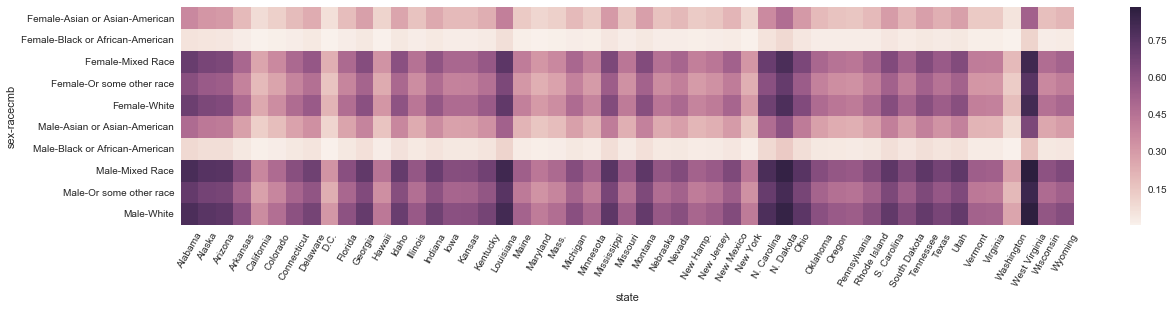

In [396]:
plt.figure(figsize=(20,4))
ax = sns.heatmap(trump_probs)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)

Actually, I think I'll go with the original chart w/ the state names on the y axis, because they're hard to read even like this. It does mean I'll need to have a particularly tall graphic on the 16:9 slide, but I'll deal with it.

In [425]:
shorten_racecmb_values = {'Asian or Asian-American':'Asian',
                          'Black or African-American':'Black',
                          'Mixed Race':'Mixed',
                          'Or some other race':'Other',
                          'White':'White'}

In [433]:
trump_probs_by_state = all_cells.pivot_table(columns=['sex','racecmb'],index='state',values='trump_prob')
# shorten racecmb labels for display, hack per https://stackoverflow.com/questions/32892751/set-level-values-in-multiindex
trump_probs_by_state.columns = trump_probs_by_state.columns.set_levels(trump_probs_by_state.columns.levels[1].map(shorten_racecmb_values.get), "racecmb")
trump_probs_by_state.columns = [', '.join(col).strip() for col in trump_probs_by_state.columns.values]

trump_probs_by_state[:3]

,"Female, Asian","Female, Black","Female, Mixed","Female, Other","Female, White","Male, Asian","Male, Black","Male, Mixed","Male, Other","Male, White"
state,,,,,,,,,,
Alabama,0.367146,0.060216,0.708246,0.611295,0.694567,0.485930,0.094530,0.798197,0.719291,0.787471
Alaska,0.318009,0.048978,0.661150,0.558310,0.646366,0.431742,0.077416,0.760716,0.673156,0.748625
Arizona,0.307900,0.046833,0.650538,0.546685,0.635546,0.420245,0.074124,0.752053,0.662728,0.739674


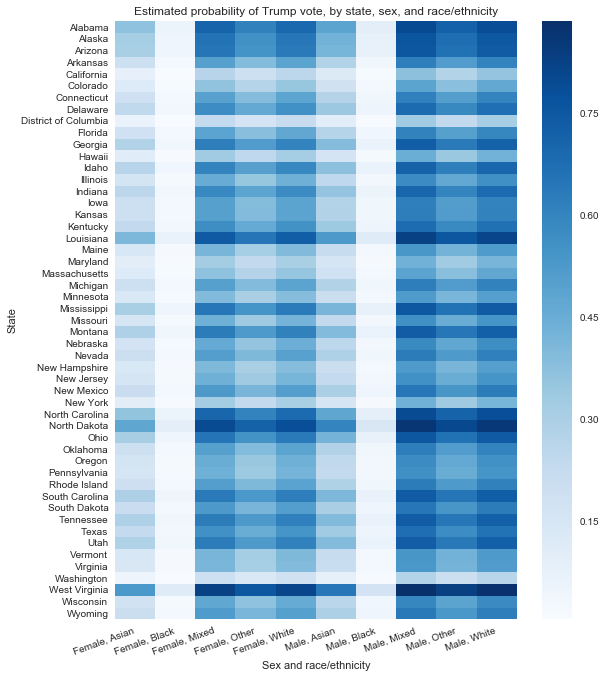

In [458]:
plt.figure(figsize=(9,11))
ax = sns.heatmap(trump_probs_by_state, cmap='Blues')

ax.set_title('Estimated probability of Trump vote, by state, sex, and race/ethnicity')
ax.set_ylabel('State')
ax.set_xlabel('Sex and race/ethnicity')

# rotate and shift x axis labels by a bit for aesthetic reasons
for i, tick in enumerate(ax.get_xticklabels()):
    tick.set_rotation(20)
    tick.set_ha('right')

Side note: changing the SD on the beta_state params does appear to have kept the indiv state coefs, for those states w/ small amts of data, from blowing out and overwhelming the impact of the sex and race coefs. I don't know if it's caused too much impact on the other states - hopefully not, because they have enough data that they can still end up where they should be? I want to check w/ the actual changes below in the post-stratified predictions.

## Comparison of results, by method

In [492]:
result_comparison

,Clinton count,Clinton proportion,Trump count,Trump proportion,Total count
Bayesian MRP,180742046.0,0.566823,138126436.0,0.433177,318868482.0
"Pew Research, weighted",2628.0,0.535889,2276.0,0.464111,4904.0
"Pew Research, unweighted",972.0,0.531148,858.0,0.468852,1830.0
Bayesian MRP (adjusted for likelihood of voting),129211403.0,0.567438,98498934.0,0.432562,227710337.0
Logistic regression (OLS),180278476.0,0.565369,138590026.0,0.434631,318868502.0


# Save generated raw results/data

In [494]:
all_cells_with_results_and_adj_voted_data_and_lr.to_csv('mrp_cells.csv')

# Findings

# Discussion

# References

- http://andrewgelman.com/2016/10/12/31398/
- http://andrewgelman.com/2013/10/09/mister-p-whats-its-secret-sauce/
- http://www.princeton.edu/~jkastell/MRP_primer/mrp_primer.pdf
- https://github.com/pymc-devs/pymc3

TBD also refer to the project research notebook.

NOTE: Ideally I'd use Markdown reference-style links, as described in the [Daring Fireball Markdown docs](https://daringfireball.net/projects/markdown/syntax#link), but it looks like they're not supported by Jupyter Notebook at least, so I'll just use inline-style links in the body of the notebook and here.